# Imperfect HWP simulation

Normalized inverted_s_in: [1.00000000e+00 1.01075318e-02 1.44231419e-04]
Normalized inverted_s_in: [1.00000000e+00 1.00140411e-02 6.35193053e-05]
Normalized inverted_s_in: [ 1.00000000e+00  1.00281509e-02 -1.20319467e-04]
Normalized inverted_s_in: [ 1.00000000e+00  9.82522505e-03 -1.31921405e-04]
Normalized inverted_s_in: [1.00000000e+00 1.00934529e-02 2.58330733e-04]
Normalized inverted_s_in: [1.00000000e+00 9.94484025e-03 2.64430562e-04]
Normalized inverted_s_in: [1.00000000e+00 1.00182492e-02 1.54689018e-04]
Normalized inverted_s_in: [1.00000000e+00 9.90491055e-03 1.07111910e-04]
Normalized inverted_s_in: [ 1.00000000e+00  1.02433697e-02 -1.47434161e-04]
Normalized inverted_s_in: [ 1.00000000e+00  1.00137948e-02 -5.70910651e-05]
Normalized inverted_s_in: [ 1.00000000e+00  1.01051194e-02 -2.37934014e-04]
Normalized inverted_s_in: [ 1.00000000e+00  9.88495888e-03 -3.73842724e-04]
Normalized inverted_s_in: [ 1.00000000e+00  9.79255290e-03 -1.56677135e-04]
Normalized inverted_s_in: [ 1.

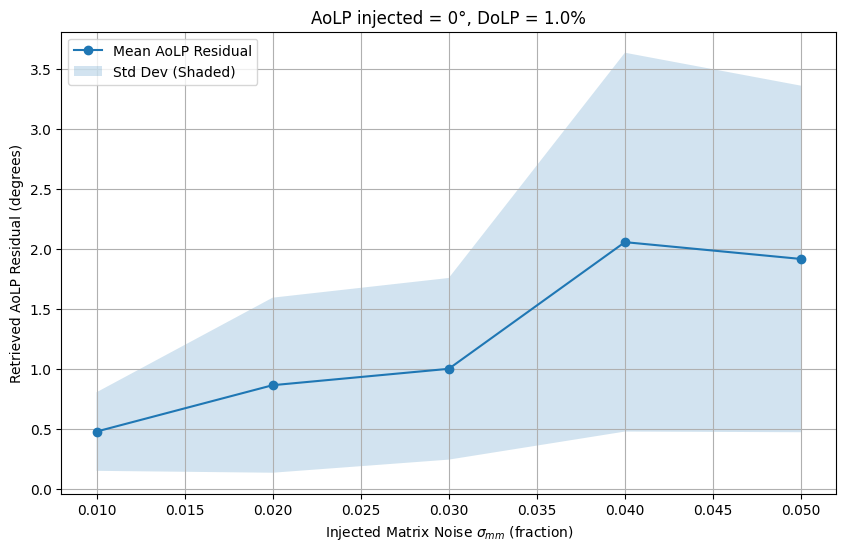

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, '../../python/')
import angles
import instrument_mm

# -----------------------------------------
# Observer / target configuration
# -----------------------------------------
observer_latitude = 20.0   # Mauna Kea [deg]
observer_longitude = -155.5
targets = [{"name": "Hamal", "ra": 31.791, "dec": 23.462}]

# Observation date/time
observation_date = "2460614.91667"  # JD for 2024-10-31
observation_time = "10:00:00"       # UT time
matrix_noise_type = "additive"

# -----------------------------------------
# Integration / simulation parameters
# -----------------------------------------
t_int = 60          # total integration per trial [s]
sub_tint = 1        # subintegration [s]
num_samples = 100   # internal sampling steps in your instrument_mm function

DoLP = 0.01         # Injected DoLP (1%)
AoLP_injected = 0.0 # << Fix AoLP at 0 degrees
noise_percentage = 0
HWP_noise = 0
delta_HWP = 0.5     # HWP retardance in waves
num_trials = 50     # trials per sigma_mm value

# Sweep injected matrix noise (fractional) from 0.01 to 0.05 inclusive
sigma_mm_vals = np.arange(0.01, 0.051, 0.01)  # 0.01, 0.02, ..., 0.05

# -----------------------------------------
# Helper functions
# -----------------------------------------
def aolp_to_stokes(dolp, aolp_deg):
    a = np.radians(aolp_deg)
    Q = dolp * np.cos(2 * a)
    U = dolp * np.sin(2 * a)
    return Q, U

def stokes_to_aolp_deg(Q, U):
    a2 = np.degrees(np.arctan2(U, Q))  # angle for 2*AoLP
    a = 0.5 * a2
    if a < 0:
        a += 180.0
    return a

def aolp_residual_deg(a_inj, a_ret):
    d = abs(a_inj - a_ret)
    if d > 90:
        d = 180 - d
    return d

# -----------------------------------------
# Output file setup
# -----------------------------------------
notebook_name = os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else "HWP_AoLP_residuals_varying_matrix_noise"
output_dir = "../numpy_files"
os.makedirs(output_dir, exist_ok=True)
txt_path = os.path.join(output_dir, notebook_name + ".txt")

with open(txt_path, "w") as f:
    # Header
    f.write("sigma_mm_frac, mean_residual_deg, std_residual_deg, target_name, target_ra, target_dec\n")

    for target in targets:
        mean_residuals = []
        std_residuals = []

        # Injected Stokes for AoLP = 0
        Q_inj, U_inj = aolp_to_stokes(DoLP, AoLP_injected)

        for sigma_mm in sigma_mm_vals:
            residuals = []

            # instrument_mm expects percent (e.g. 5 for 5%)
            sigma_mm_percent = 100.0 * sigma_mm

            for _ in range(num_trials):
                S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                    ra=target["ra"],
                    dec=target["dec"],
                    observer_latitude=observer_latitude,
                    observer_longitude=observer_longitude,
                    jd_str=observation_date,
                    ut_start=observation_time,
                    t_int=t_int,
                    Q=Q_inj,
                    U=U_inj,
                    delta_HWP=delta_HWP,
                    noise_percentage=noise_percentage,
                    include_V=False,
                    sub_tint=sub_tint,
                    TMT_matrix_noise=sigma_mm_percent,
                    NFIRAOS_matrix_noise=sigma_mm_percent,
                    MODHIS_matrix_noise=sigma_mm_percent,
                    observable="intensities",
                    sampled_steps=num_samples,
                    matrix_noise_type=matrix_noise_type,
                    HWP_noise=HWP_noise,
                    normalize_s_out=True,
                )

                # Retrieved AoLP
                Q_ret, U_ret = S_in_retrieved[1], S_in_retrieved[2]
                aolp_ret = stokes_to_aolp_deg(Q_ret, U_ret)
                residuals.append(aolp_residual_deg(AoLP_injected, aolp_ret))

            # Store mean ± std
            m = np.mean(residuals)
            s = np.std(residuals)
            mean_residuals.append(m)
            std_residuals.append(s)

            # Write row to txt
            f.write(f"{sigma_mm:.3f}, {m:.8f}, {s:.8f}, {target['name']}, {target['ra']}, {target['dec']}\n")

print(f"Saved summary data to {txt_path}")

# -----------------------------------------
# Plot results
# -----------------------------------------
data = np.loadtxt(txt_path, delimiter=",", skiprows=1, dtype=str)
sigma_mm_loaded = data[:,0].astype(float)
mean_residuals = data[:,1].astype(float)
std_residuals = data[:,2].astype(float)

plt.figure(figsize=(10,6))
plt.plot(sigma_mm_loaded, mean_residuals, '-o', label="Mean AoLP Residual")
plt.fill_between(sigma_mm_loaded,
                 mean_residuals - std_residuals,
                 mean_residuals + std_residuals,
                 alpha=0.2, label="Std Dev (Shaded)")

plt.xlabel(r"Injected Matrix Noise $\sigma_{mm}$ (fraction)")
plt.ylabel("Retrieved AoLP Residual (degrees)")
plt.title(f"AoLP injected = {AoLP_injected:.0f}°, DoLP = {DoLP*100:.1f}%")
plt.grid(True)
plt.legend()
plt.show()


# Recreating plot

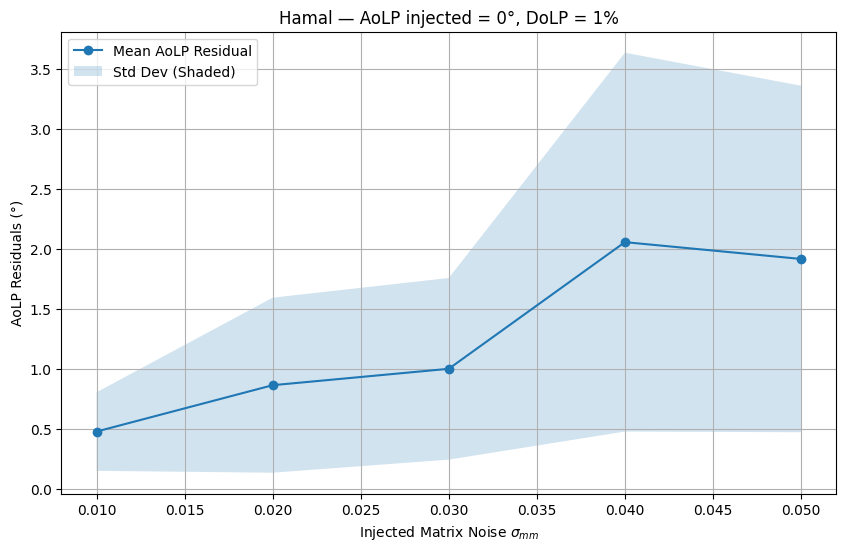

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------
# Path to saved .txt file
# -----------------------------
txt_path = "/home/rebeccaz/Github/modhis_polarimetry_feasibility_study/results/numpy_files/HWP_AoLP_residuals_varying_matrix_noise.txt"

# -----------------------------
# Load data
# -----------------------------
data = []
with open(txt_path, "r") as f:
    header = f.readline()  # skip header
    for line in f:
        parts = line.strip().split(",")
        if len(parts) < 6:
            continue
        sigma_mm = float(parts[0])
        mean_residual = float(parts[1])
        std_residual = float(parts[2])
        target_name = parts[3].strip()
        target_ra = float(parts[4])
        target_dec = float(parts[5])
        data.append((sigma_mm, mean_residual, std_residual, target_name, target_ra, target_dec))

data = np.array(data, dtype=object)

# -----------------------------
# Plot (from saved txt)
# -----------------------------
for target_name in np.unique(data[:,3]):
    mask = data[:,3] == target_name
    sigma_mm_vals = data[mask,0].astype(float)
    mean_residuals = data[mask,1].astype(float)
    std_residuals = data[mask,2].astype(float)

    plt.figure(figsize=(10,6))
    plt.plot(sigma_mm_vals, mean_residuals, '-o', label="Mean AoLP Residual")
    plt.fill_between(sigma_mm_vals,
                     mean_residuals - std_residuals,
                     mean_residuals + std_residuals,
                     alpha=0.2, label="Std Dev (Shaded)")

    plt.xlabel(r"Injected Matrix Noise $\sigma_{mm}$")
    plt.ylabel("AoLP Residuals (°)")  # degree symbol
    plt.title(f"{target_name} — AoLP injected = 0°, DoLP = 1%")
    plt.grid(True)
    plt.legend()
    plt.show()
